# B7. Extra Diagnostic Plots for Basel Rain Model

This notebook reuses the tuned logistic regression model from earlier notebooks
and focuses on additional diagnostic plots:

1. Predicted rain probabilities by true class (rain vs no rain).
2. Calibration curve for predicted rain probabilities.
3. Rain recall by month in the 2008–2010 test period.

These figures provide visual evidence about how well the model separates the
classes, how trustworthy its probabilities are, and how performance varies
seasonally.


In [1]:
# 1. Setup and Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120


## 1. Load Processed Basel Data and Time-Aware Split

I load the same processed Basel feature table (`basel_rain_features.csv`) used
in earlier notebooks, sort by date, and create the same 80/20 chronological
train–test split (train up to 2008-01-01, test from 2008-01-02 onward).


In [2]:

PROC_PATH = "/Users/purvigarg/Downloads/CMSE492/cmse492_project/data/processed/basel_rain_features.csv"

df = pd.read_csv(PROC_PATH)
print("Loaded processed:", df.shape)

df["DATE"] = pd.to_datetime(df["DATE"].astype(str), errors="coerce")
df = df.sort_values("DATE").reset_index(drop=True)

# define X and y
y = df["RainTomorrow"].astype(int)
feature_cols = [c for c in df.columns if c not in ["DATE", "RainTomorrow"]]
X = df[feature_cols].copy()

print("Feature columns:", feature_cols)
print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts(normalize=True).rename("proportion"))

# chronological 80/20 split
n = len(df)
split_idx = int(0.8 * n)

X_train = X.iloc[:split_idx].copy()
y_train = y.iloc[:split_idx].copy()

X_test = X.iloc[split_idx:].copy()
y_test = y.iloc[split_idx:].copy()

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train dates:", df["DATE"].iloc[0], "→", df["DATE"].iloc[split_idx - 1])
print("Test dates:", df["DATE"].iloc[split_idx], "→", df["DATE"].iloc[-1])


Loaded processed: (3653, 12)
Feature columns: ['MONTH', 'RainToday', 'BASEL_pressure', 'BASEL_humidity', 'BASEL_temp_mean', 'BASEL_sunshine', 'BASEL_pressure_lag1', 'BASEL_humidity_lag1', 'BASEL_temp_mean_lag1', 'BASEL_sunshine_lag1']
X shape: (3653, 10)
y distribution:
RainTomorrow
0    0.532987
1    0.467013
Name: proportion, dtype: float64
Train shape: (2922, 10) Test shape: (731, 10)
Train dates: 2000-01-02 00:00:00 → 2008-01-01 00:00:00
Test dates: 2008-01-02 00:00:00 → 2010-01-01 00:00:00


## 2. Rebuild Tuned Logistic Regression

I rebuild the final logistic regression model with the hyperparameters found in
B5/B6 (`C = 3.0`, `class_weight = "balanced"`, `max_iter = 2000`) so that all
plots in this notebook are based on the same model.


In [3]:
logreg_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        C=3.0,
        class_weight="balanced",
        max_iter=2000,
        solver="lbfgs"
    )),
])

logreg_clf.fit(X_train, y_train)

y_pred = logreg_clf.predict(X_test)
y_proba = logreg_clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Test accuracy:", f"{acc:.3f}")
print("Test F1 (Rain):", f"{f1:.3f}")


Test accuracy: 0.668
Test F1 (Rain): 0.668


## 3. Predicted Rain Probabilities by True Class

This plot compares the logistic model’s predicted probability of rain tomorrow
for days that were actually dry versus days that were actually rainy in the
test set. The dashed line marks the default 0.5 decision threshold.


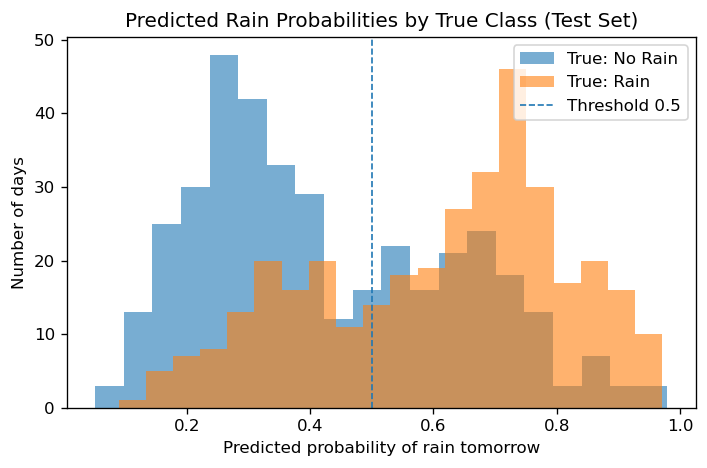

In [4]:
y_proba = logreg_clf.predict_proba(X_test)[:, 1]

rain_mask = (y_test == 1)
norain_mask = (y_test == 0)

plt.figure(figsize=(6,4))
plt.hist(y_proba[norain_mask], bins=20, alpha=0.6, label="True: No Rain")
plt.hist(y_proba[rain_mask],   bins=20, alpha=0.6, label="True: Rain")
plt.axvline(0.5, linestyle="--", linewidth=1, label="Threshold 0.5")
plt.xlabel("Predicted probability of rain tomorrow")
plt.ylabel("Number of days")
plt.title("Predicted Rain Probabilities by True Class (Test Set)")
plt.legend()
plt.tight_layout()
plt.savefig("/Users/purvigarg/Downloads/CMSE492/cmse492_project/figures/Predicted_Rain_Probabilities.png")
plt.show()



Dry days are mostly assigned low rain probabilities (peaking around 0.2–0.3),
while rainy days are mostly assigned higher probabilities (around 0.7–0.8).
There is overlap in the middle (roughly 0.3–0.6), which explains why some days
are hard to classify, but overall the model creates a clear separation between
the two classes and a threshold near 0.5 cuts sensibly between them.


## 4. Calibration Curve for RainTomorrow

This calibration curve groups test days into bins by predicted rain probability
and compares the average predicted probability in each bin to the actual
fraction of rainy days. A perfectly calibrated model would lie on the diagonal
`y = x`.


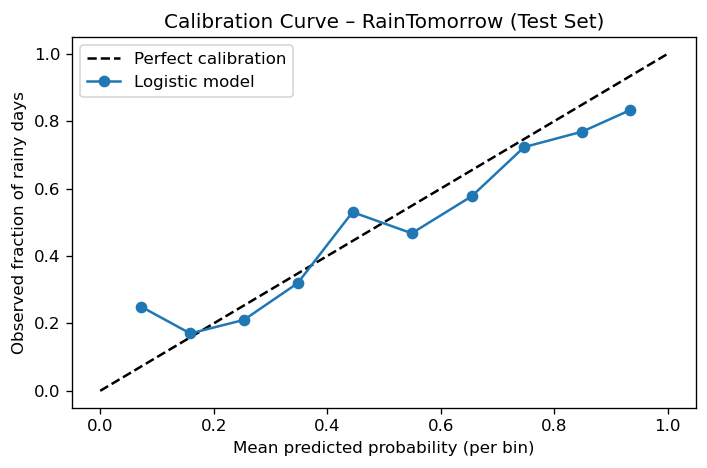

,bin,mean_pred,mean_obs
0,0,0.071756,0.250000
1,1,0.158711,0.170213
2,2,0.253279,0.210526
3,3,0.347857,0.319328
4,4,0.444713,0.530303
5,5,0.549024,0.467532
6,6,0.654847,0.577586
7,7,0.747076,0.723214
8,8,0.849567,0.769231
9,9,0.934275,0.833333


In [5]:
bins = np.linspace(0, 1, 11)  # 10 bins: 0–0.1, 0.1–0.2, ...
bin_ids = np.digitize(y_proba, bins) - 1  # indices 0..9

calib_rows = []
for b in range(10):
    mask = (bin_ids == b)
    if mask.sum() == 0:
        continue
    mean_pred = y_proba[mask].mean()
    mean_obs = y_test[mask].mean()  # fraction of rainy days in this bin
    calib_rows.append({"bin": b, "mean_pred": mean_pred, "mean_obs": mean_obs})

calib_df = pd.DataFrame(calib_rows)

plt.figure(figsize=(6,4))
plt.plot([0,1], [0,1], "k--", label="Perfect calibration")
plt.plot(calib_df["mean_pred"], calib_df["mean_obs"], marker="o", label="Logistic model")
plt.xlabel("Mean predicted probability (per bin)")
plt.ylabel("Observed fraction of rainy days")
plt.title("Calibration Curve – RainTomorrow (Test Set)")
plt.legend()
plt.tight_layout()
plt.savefig("/Users/purvigarg/Downloads/CMSE492/cmse492_project/figures/Calibration_curve_raintomorrow.png")
plt.show()
plt.show()

calib_df



The calibration points mostly follow the diagonal: when the model predicts a
30–40% chance of rain, it rains in roughly 30–40% of those cases, and when it
predicts a 70–80% chance, it rains on the majority of those days. The model is
slightly under-confident in some mid-range bins, but overall the probabilities
are reasonably well calibrated, so they can be interpreted as meaningful “chance
of rain” estimates.


## 5. Rain Recall by Month (Seasonal Behavior)

To understand when the model struggles most, I examine recall for rainy days in
each calendar month of the 2008–2010 test period. High recall means that most
rain events in that month are correctly predicted as rain.


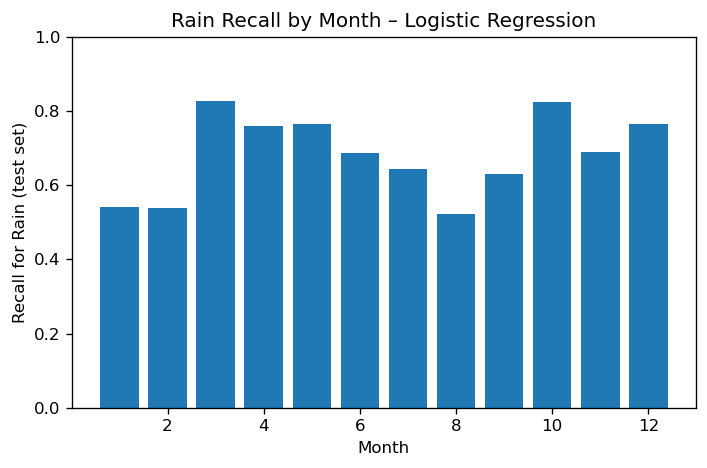

,MONTH,recall_rain
0,1,0.541667
1,2,0.538462
2,3,0.828571
3,4,0.758621
4,5,0.764706
5,6,0.687500
6,7,0.645161
7,8,0.521739
8,9,0.631579
9,10,0.823529


In [6]:

# take the test portion of the original dataframe
df_test = df.iloc[split_idx:].copy().reset_index(drop=True)

# attach true and predicted labels
df_test["y_true"] = y_test.values          # y_test is a pandas Series
df_test["y_pred"] = y_pred                 # y_pred is already a NumPy array

# make sure MONTH is an integer
df_test["MONTH"] = df_test["MONTH"].astype(int)

month_rows = []
for m in sorted(df_test["MONTH"].unique()):
    subset = df_test[df_test["MONTH"] == m]
    true_rain = subset["y_true"] == 1
    if true_rain.sum() == 0:
        continue

    # TP and FN for that month
    tp = ((subset["y_pred"] == 1) & (subset["y_true"] == 1)).sum()
    fn = ((subset["y_pred"] == 0) & (subset["y_true"] == 1)).sum()
    recall_m = tp / (tp + fn)

    month_rows.append({"MONTH": m, "recall_rain": recall_m})

month_df = pd.DataFrame(month_rows)

plt.figure(figsize=(6,4))
plt.bar(month_df["MONTH"], month_df["recall_rain"])
plt.xlabel("Month")
plt.ylabel("Recall for Rain (test set)")
plt.title("Rain Recall by Month – Logistic Regression")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("/Users/purvigarg/Downloads/CMSE492/cmse492_project/figures/rain_recall_LR.png")
plt.show()

month_df



Rain recall stays above about 0.5 in every month but clearly varies with
season. The model tends to catch a larger fraction of rainy days in some
spring and autumn months (recall around 0.8) and performs more modestly in
certain winter and late-summer months (recall closer to 0.5–0.6). This shows
that the difficulty of the forecasting task depends on the time of year and
provides a concrete way to discuss seasonal strengths and weaknesses in the
final report.


## 6. Conclusion

This notebook collects extra diagnostic plots for the tuned logistic regression
rain/no-rain model. The predicted-probability histograms show that the model
creates a meaningful separation between rainy and dry days, with most dry days
receiving low probabilities and most rainy days receiving high probabilities.
The calibration curve demonstrates that these probabilities are reasonably
well aligned with observed frequencies, so they can be interpreted as true
“chance of rain” estimates. Finally, the monthly recall plot reveals seasonal
variation in performance, suggesting that some parts of the year are easier to
forecast than others.

These visual diagnostics complement the numeric metrics from earlier notebooks
and strengthen the overall story that a small, physics-guided feature set plus
a tuned logistic regression provides a transparent and reasonably reliable
day-ahead rain predictor for Basel.
